# Data Challenge-Ultimate
_Note: Please refer to the pdf for instructions_

Some considerations:
- The entire analysis uses plotly for visualisation.
- Change the THEME to 'dark' in the succeeding cell to enable Dark Mode.
- The graphs are rendered as 'svg' images. It can be changed to 'png' or 'jpeg'.
- The graphs can be rendered as interactive by specifying no argument in ```figure.show()```

## Section 0

#### Define constants and import necessary libraries

In [5]:
THEME = 'light'

In [6]:
Portland_colours = ['rgb(12, 51, 131)', 
                    'rgb(10, 136, 186)', 
                    'rgb(242, 211, 56)',
                    'rgb(242, 10, 250)', 
                    'rgb(242, 243, 56)', 
                    'rgb(217, 243, 30)',
                    'rgb(217, 30, 30)']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [7]:
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
import json

from collections import Counter

import statsmodels.api as sm 
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 18, 8

from sklearn.model_selection import train_test_split, VarianceThreshold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

ImportError: cannot import name 'VarianceThreshold' from 'sklearn.model_selection' (/Users/satyasiddharthdash/ml/lib/python3.7/site-packages/sklearn/model_selection/__init__.py)

## Section 1: Exploratory Data Analysis

#### Read in the login data

In [8]:
logins_df = pd.read_json('../ultimate_challenge/logins.json')
data_df = pd.read_json('../ultimate_challenge/ultimate_data_challenge.json')

#### Initial exploration

In [9]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [10]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


#### Necessary datatype conversions and aggregations
Convert the ```login time``` to datetime format.
Aggregate the data by the following time periods:
1. 15 min
2. 1 Hour
3. 1 Day

In [11]:
logins_df['login_time'] = logins_df['login_time'].astype('datetime64')
logins_df = logins_df.set_index('login_time')
logins_df['count'] = 1
logins_agg = []
for time_interval in ['15T', 'H', 'D']:
    logins_agg.append(logins_df.resample(time_interval).count()['count'])

Let us first plot the 15-min aggregated data and look for patterns

#### Plot 15-minute logins

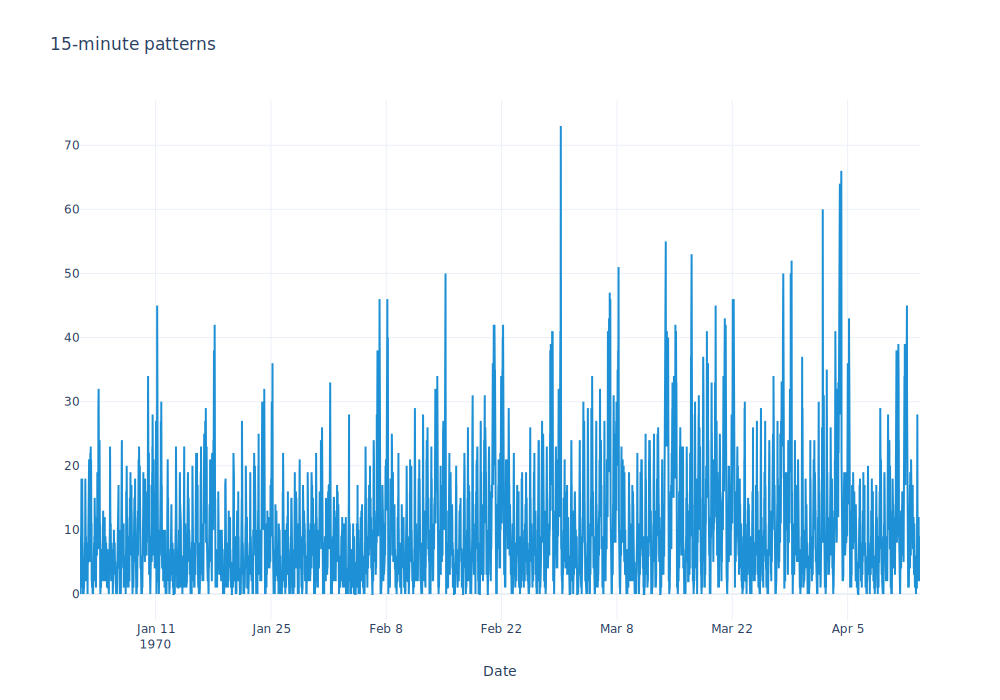

In [12]:
trace_all = dict(x = logins_agg[0].index,
                 y = logins_agg[0].values,
                 mode = 'lines',
                 marker = dict(color = '#1e91d6'))
layout = dict(title = '15-minute patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = go.Scatter(trace_all),
                layout = layout)
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1000', height = '700')

As can be seen, there is clearly a cyclic pattern.
Let us check for patterns in the hourly data.

#### Plot Hourly logins

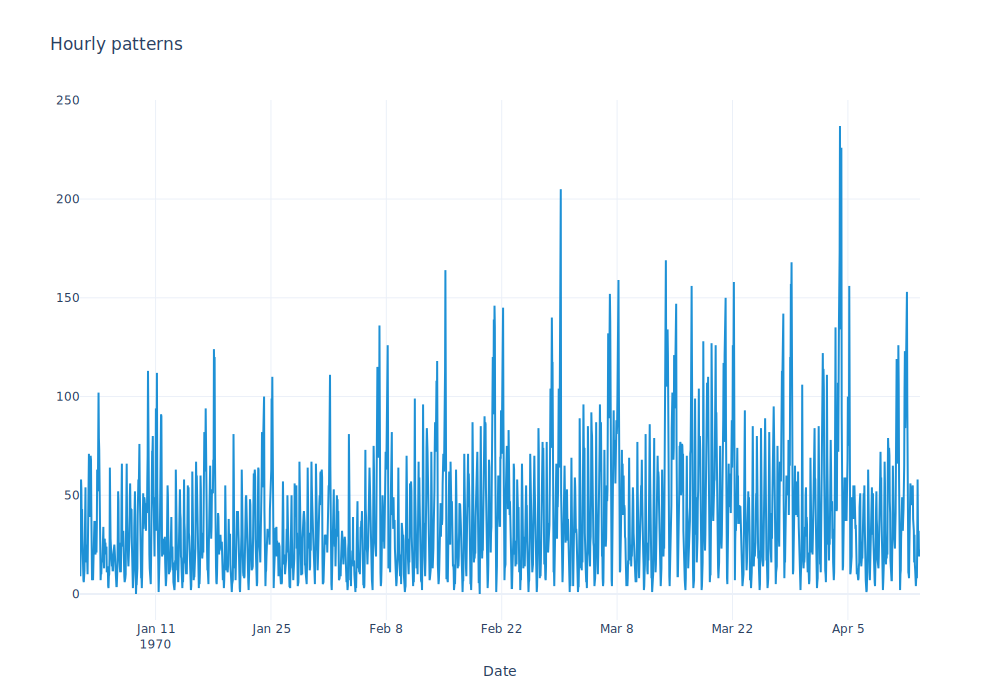

In [13]:
trace_all = dict(x = logins_agg[1].index,
                 y = logins_agg[1].values,
                 mode = 'lines',
                 marker = dict(color = '#1e91d6'))
layout = dict(title = 'Hourly patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = go.Scatter(trace_all),
                layout = layout)
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1000', height = '700')

The patterns become clearer now. Different times of the day 
entail different number of logins. Let us look at daily logins.

#### Plot Daily logins

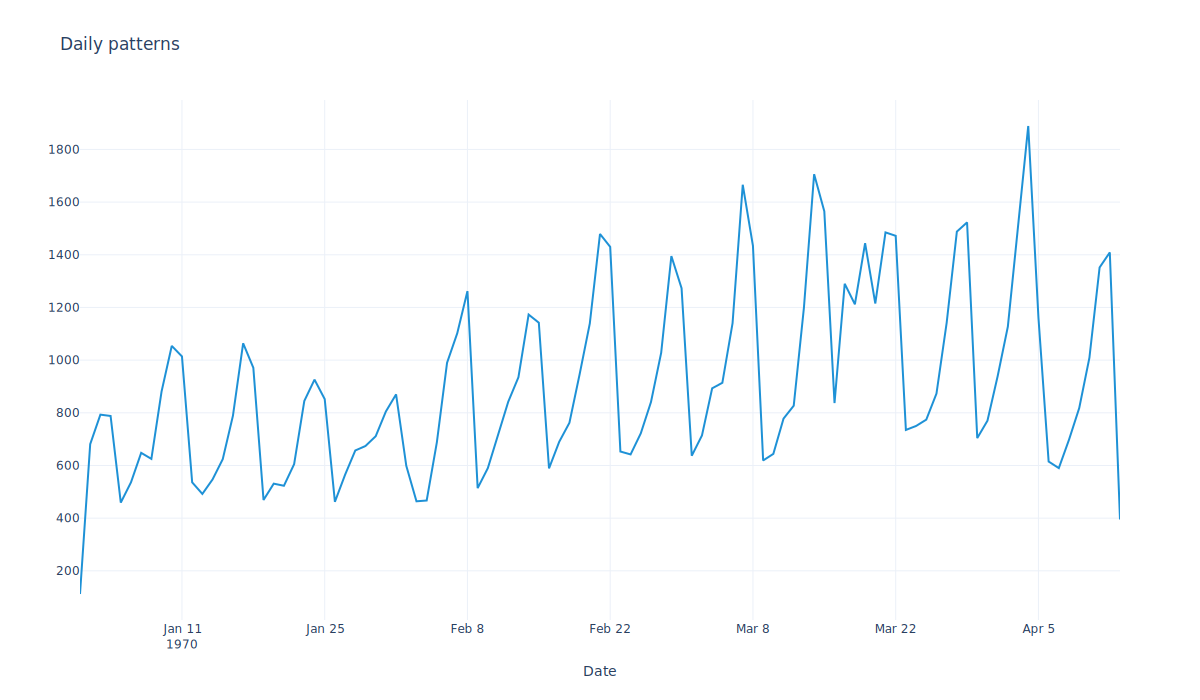

In [14]:
trace_daily = dict(x = logins_agg[2].index,
                        y = logins_agg[2].values,
                 mode = 'lines',
                 name = 'daily',
                 marker = dict(color = '#1e91d6'))
layout = dict(title = 'Daily patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Scatter(trace_daily)],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

There is a cylic pattern which most probably repeats weekly.
Let us check that.

#### Weekday patterns
Let us check how the logins differed on different weekdays

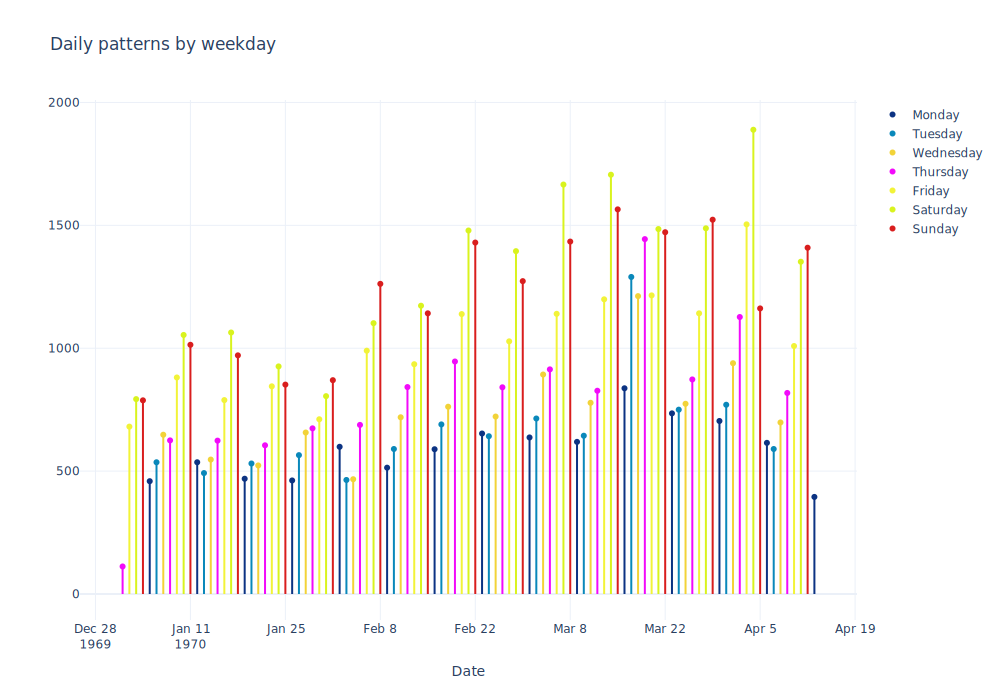

In [15]:
trace_weekdaywise = [dict(x = logins_agg[2].index,
                 y = logins_agg[2].reset_index()
                                  .apply(lambda x: x['count'] if x['login_time'].day_name() == weekday_name else None, axis = 1)
                                  .values,
                 error_y = dict(type = 'data',
                                symmetric = False,
                                arrayminus = logins_agg[2].reset_index()
                                                          .apply(lambda x: x['count'] if x['login_time']
                                                                                         .day_name() == weekday_name else None, axis = 1)
                                                          .values,
                                array = 0 * list(logins_agg[2].index), 
                                width = 0,
                                color = day_color),
                 mode = 'markers',
                 name = weekday_name,
                 marker = dict(color = day_color)) for weekday_name, day_color in zip(days, Portland_colours)]
layout = dict(title = 'Daily patterns by weekday', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Scatter(trace) for trace in trace_weekdaywise],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1000', height = '700')

Clearly different days have different levels of activity. 
Let us observe the total number of logins on different days of the week

#### Plot of total logins by weekday

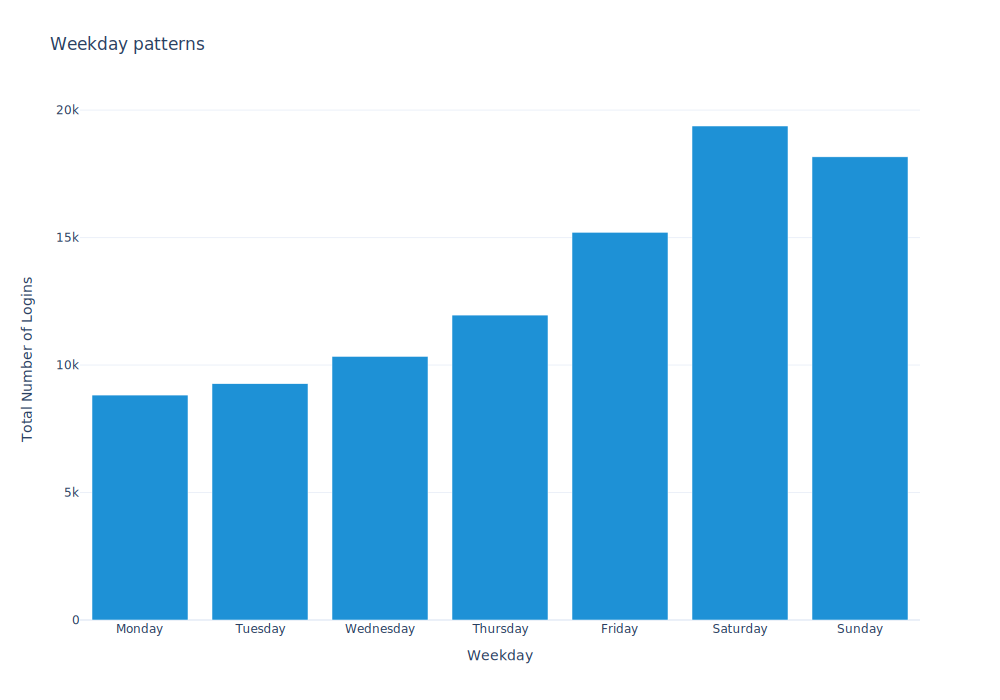

In [16]:
logins_df['hour'] = logins_df.index.hour
logins_df['day'] = logins_df.index.weekday
bar_weekday = dict(y = logins_df.groupby('day').sum()['count'],
                    x = days,
                marker = dict(color = '#1e91d6'))
layout = dict(title = 'Weekday patterns', 
              xaxis_title = 'Weekday', 
              yaxis_title = 'Total Number of Logins',
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Bar(bar_weekday)],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1000', height = '700')

Let us now see how the number of logins differ during throughout the day during different days of the week.

#### Plot of Hourly patterns on different weekdays

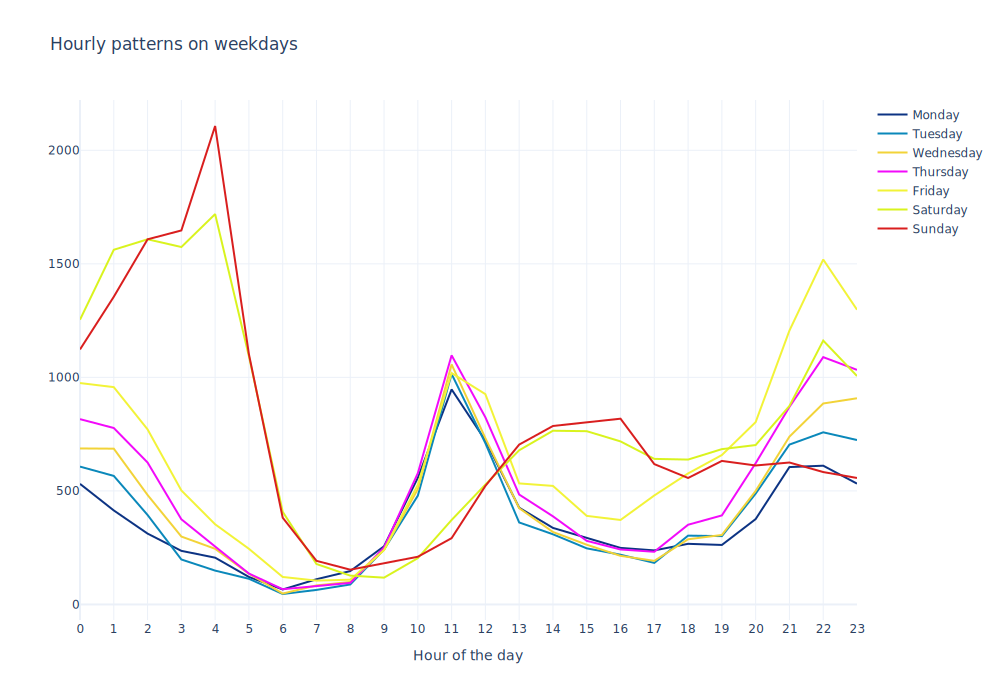

In [17]:
grouped = logins_df.groupby(['day', 'hour']).sum().reset_index()
bar_grouped = [dict(y = grouped[grouped['day'] == weekday_number]['count'],
                   x = grouped['hour'],
                   mode = 'lines',
                   name = day,
                   marker = dict(color = color)) for weekday_number, color, day in zip(range(7), Portland_colours, days)]
layout = dict(title = 'Hourly patterns on weekdays', 
              xaxis_title = 'Hour of the day',
              xaxis_nticks = 24,
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Scatter(bar) for bar in bar_grouped],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1000', height = '700')

Some observations:
- On working days, there is a lot of activity at beginning of office hours and again at the end of the working hours.
- On working days there is also a medium level of activity early in the morning.
- There is a huge spile of activity on the weekends especially in the mornings.
- On Fridays, there is a lot of activity at night.

Let us create a heatmap of the above patterns to visualize.

#### Heatmap of total logins during the day on different days of the week.

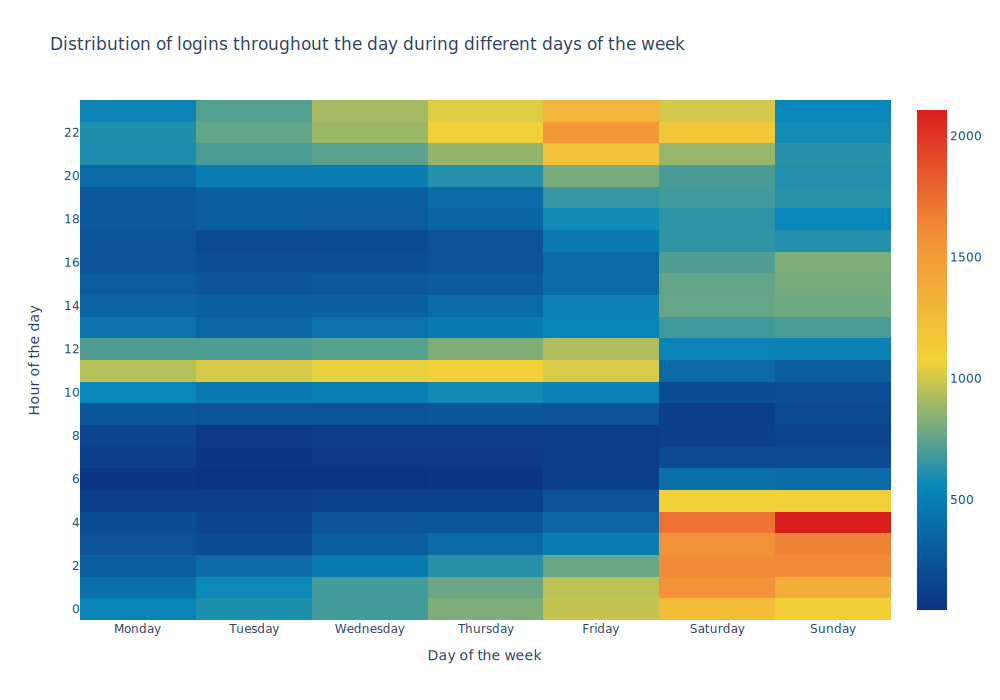

In [18]:
logins_hourly_by_weekday = logins_df.pivot_table(index = 'hour', columns = 'day', values = 'count', aggfunc = 'sum').rename({num:name for name, num in zip(days, range(7))}, axis = 1)
hourly_heatmap = dict(
                   z = logins_hourly_by_weekday.values,
                   x = logins_hourly_by_weekday.columns,
                   y = logins_hourly_by_weekday.index,
                   colorscale = 'Portland',
                   hoverongaps = False)
layout = dict(xaxis_nticks = 7,
              yaxis_nticks = 24,
              title = 'Distribution of logins throughout the day during different days of the week',
              xaxis_title = 'Day of the week',
              yaxis_title = 'Hour of the day')
fig = go.Figure(data = go.Heatmap(hourly_heatmap), layout = layout)
fig.show('svg', width = 1000, height = 700)

Let us now do a very rudimentary analysis of the patterns

#### Additive model of Seasonal patterns

Since the login data is not a financial time series, it most probably contains the following features:
<br>

1. Trends
2. Seasonality
3. Irregularity
4. Cyclic

<br>



We can use the additive seasonal decompose model from statsmodels to find patterns

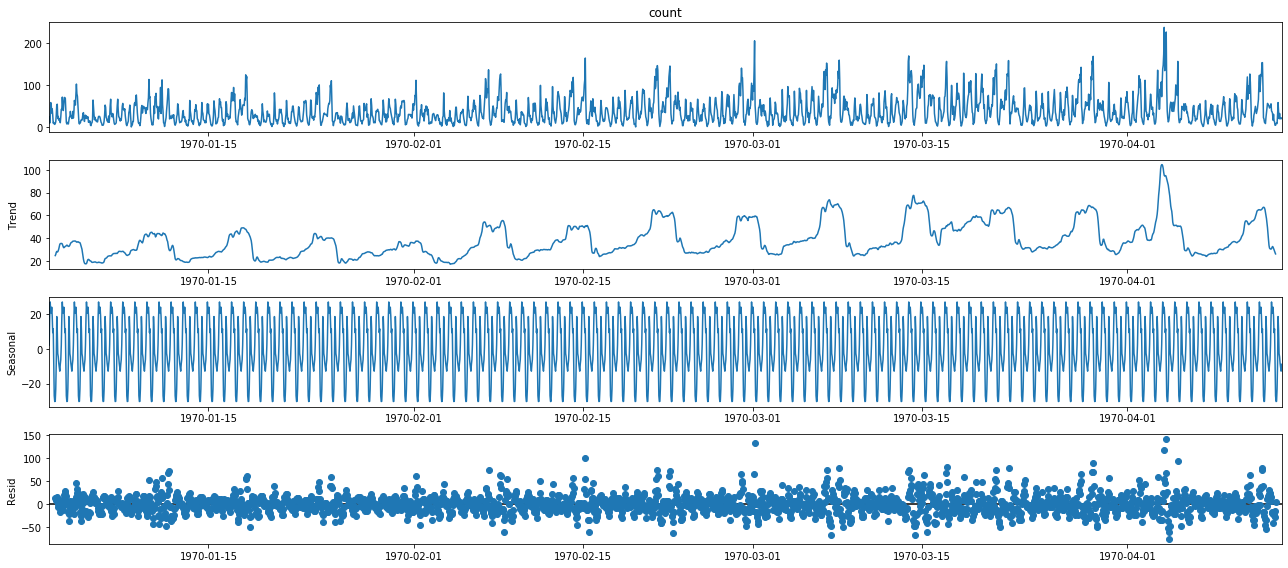

In [19]:
decomposition = sm.tsa.seasonal_decompose(logins_df.resample('H').count()['count'], model = 'additive')
fig = decomposition.plot()
plt.show()

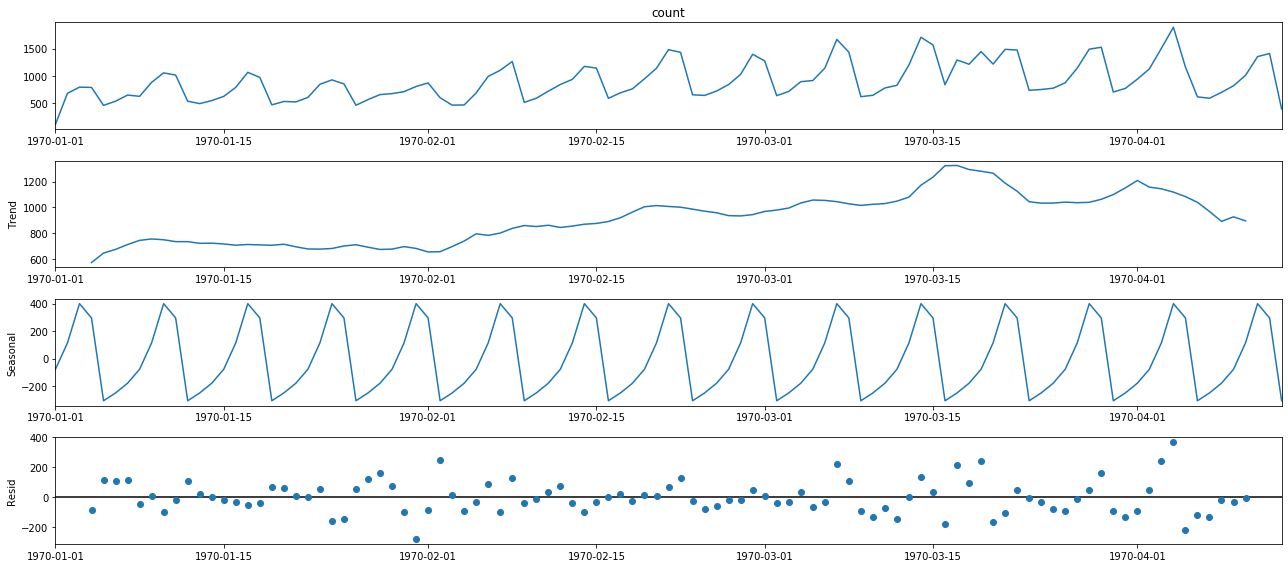

In [20]:
decomposition = sm.tsa.seasonal_decompose(logins_df.resample('D').count()['count'], model = 'additive')
fig = decomposition.plot()
plt.show()

The plots seem to agree with our previous observations. A few more observations:
1. The logins increased over February and slowly decreased in March
2. The hourly and daily patterns are pretty consistent throughout the observed time.

The additive model is very basic and does not reveal much about the data. 
The drawbacks of the model can be clearly seen by looking at the 'Resid' subplot.
This plot shows the noise in the additive model and therefore must be random, which is clearly not the case, as seen above.

Better models such as SARIMAX can be used to observe patterns more clearly. The SARIMAX model in particular can be applied effectively and a parameter search can be done to obtain the best results.

# Section 2 Experiments and Metrics design

A metric to measure the success of the experiment mentioned is the change in the average distance of the pickup and drop-off points from the city centre of the opposite city. Before the experiment, we would ideally see the average distance close the city centre of _Metropolis_ and close to the city centre of _Gotham_ at night on weekends. We would also see bi-modal distribution on the weekends. Let the metric be defined as %M%, where %M% is the difference of the distance of the pickup and drop-off points from _Metropolis_ and _Gotham_ city-centres respectively. According to this, %M% will be mostly positive at daytime and mostly negative at night on weekdays. If our experiment runs succesfully, %M% will move closer to zero during weekdays.

Other metrics we could consider are:
1. Average cost of each ride: The average cost of each ride would increase significantly if our experiment ran successfully as drivers will be driving to opposite cities and thus travel longer distances. The cost of fuel also would increase significantly(if the company is reimbursing drivers for fuel as well, this can be considered). If the costs increase too much however, it may be a result of incentivising too much. We will then be encouraging drivers to only take long trips to the opposite city and this may result in customer dissatisfaction. In order to measure our outcome, we can perform a two-tailed z-test on this metric and look for the shift.

2. The distance of the drop off points from the city centres: This metric would ideally show us that the drivers are crossing over to the opposite city, but results may be inconclusive, as drivers may be just travelling longer distances.

The following would be the details of the experiment:
* A two-tailed z-test can be performed on the value of $|M|$ described above, with a reasonable confidence level, say 95%. 
* If the change in $|M|$ is too high, then we have incentivised too much, or some other unexpected side-effect has occured. If $|M|$ is largely unchanged, then there is not much incentive for the drivers to cater to the opposite city.
* Some caveats must be taken into account while considering the above:
    * The change in the metric may be due to some other resons such as change in toll costs, season of the year, etc.
    * The experiment can be controlled and an A/B test can be done with different parameters such as full-refund vs partial-refund and so on, to observe any other outcomes.

# Section 3 Predictive Modelling

Let's read in the data first:

In [21]:
with open('../ultimate_challenge/ultimate_data_challenge.json') as inp_file:
    df = pd.DataFrame(json.load(inp_file))

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


From the problem description, the various columns are:
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after 
    signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
    FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

Let's explore the datatypes:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Let's look for missing values

In [23]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

Convert dates into the appropiate format

In [24]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

Since the both the ratings columns have missing values, we have to impute them. Here, I have chosen to impute the missing values by their medians. Other methods like using a regressor, or a classifier(for categorical columns) can also be used. 

In [41]:
df['phone'].fillna('iPhone', inplace=True)
categorical_features = df.select_dtypes(exclude = ['int64', 'float64', 'datetime64']).columns
numerical_features = df.select_dtypes(include = ['int64', 'float64']).columns
df_cat = df[categorical_features]
df_num = df[numerical_features]
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_num = pd.DataFrame(IterativeImputer(initial_strategy = 'mean').fit_transform(df_num), columns = df_num.columns)
df_num.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,4.0,4.7,1.10,15.4,46.2,3.67,5.0
1,0.0,5.0,1.00,0.0,50.0,8.26,5.0
2,3.0,4.3,1.00,0.0,100.0,0.77,5.0
3,9.0,4.6,1.14,20.0,80.0,2.36,4.9
4,14.0,4.4,1.19,11.8,82.4,3.13,4.9


In [42]:
df = pd.concat([df_num, df_cat], axis = 1)
df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city,phone,ultimate_black_user
0,4.0,4.700000,1.10,15.4,46.2,3.67,5.0,King's Landing,iPhone,True
1,0.0,5.000000,1.00,0.0,50.0,8.26,5.0,Astapor,Android,False
2,3.0,4.300000,1.00,0.0,100.0,0.77,5.0,Astapor,iPhone,False
3,9.0,4.600000,1.14,20.0,80.0,2.36,4.9,King's Landing,iPhone,True
4,14.0,4.400000,1.19,11.8,82.4,3.13,4.9,Winterfell,Android,False
...,...,...,...,...,...,...,...,...,...,...
49995,0.0,5.000000,1.00,0.0,100.0,5.63,4.2,King's Landing,iPhone,False
49996,1.0,4.432914,1.00,0.0,0.0,0.00,4.0,Astapor,iPhone,False
49997,0.0,5.000000,1.00,0.0,100.0,3.86,5.0,Winterfell,Android,True
49998,2.0,3.000000,1.00,0.0,100.0,4.58,3.5,Astapor,iPhone,False


Let's plot the distributions recieved by drivers and also the distribution of ratings given by drivers

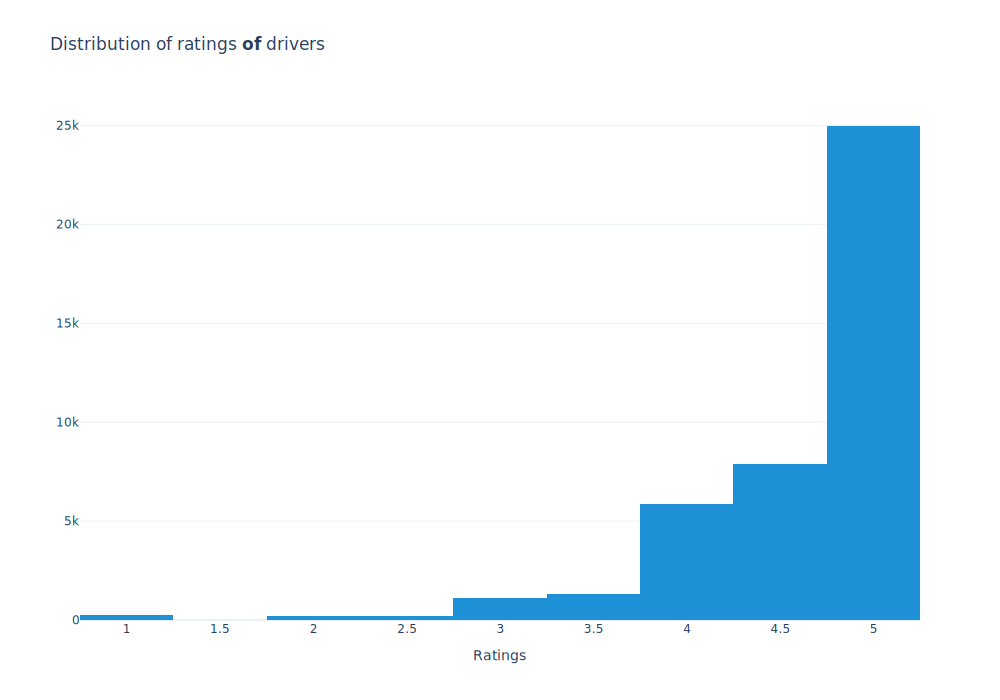

In [25]:
ratings_hist = dict(x = df['avg_rating_of_driver'],
                    nbinsx = 12,
                marker = dict(color = '#1e91d6'))
layout = dict(title = 'Distribution of ratings <b>of</b> drivers', 
              xaxis_title = 'Ratings', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Histogram(ratings_hist)],
                layout = layout)                
f = go.FigureWidget(fig)
f.show('svg', width = '1000', height = '700')

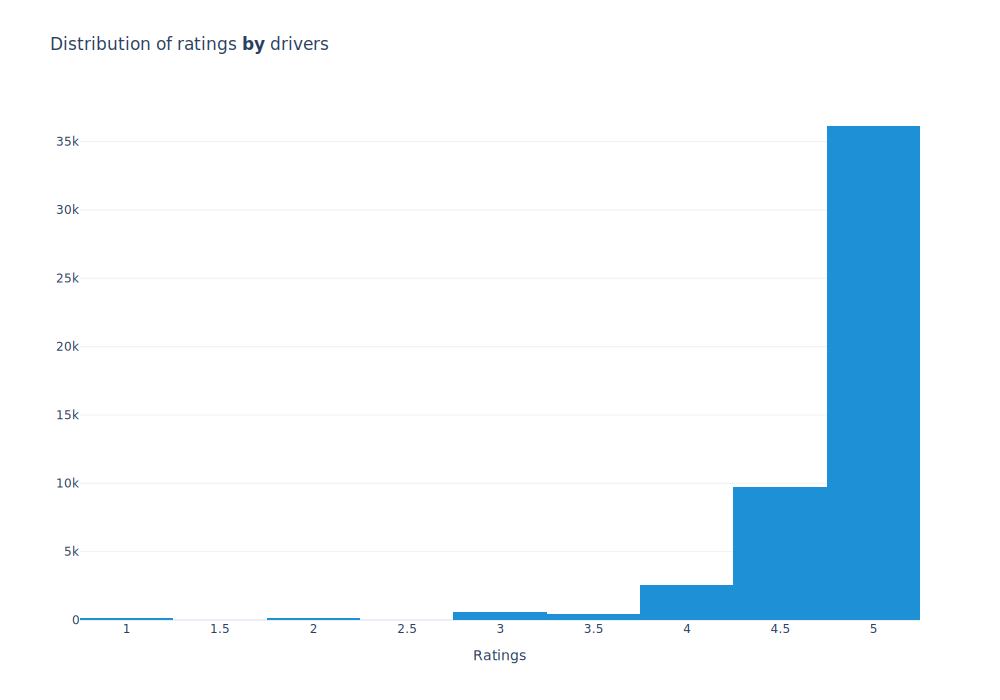

In [27]:
ratings_by_hist = dict(x = df['avg_rating_by_driver'],
                    nbinsx = 12,
                marker = dict(color = '#1e91d6'))
layout = dict(title = 'Distribution of ratings <b>by</b> drivers', 
              xaxis_title = 'Ratings', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Histogram(ratings_by_hist)],
                layout = layout)                
f = go.FigureWidget(fig)
f.show('svg', width = '1000', height = '700')

Let's look at what phones they use:

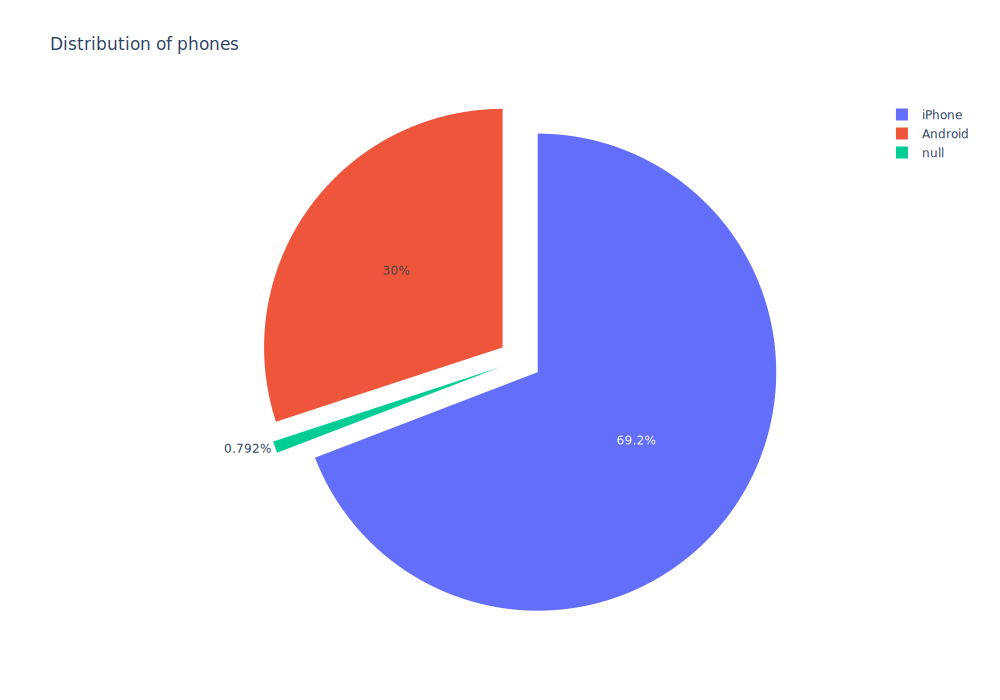

In [28]:
phone_hist = dict(labels = df['phone'], 
                    pull = 0.09)
layout = dict(title = 'Distribution of phones', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Pie(phone_hist)],
                layout = layout)                
f = go.FigureWidget(fig)
f.show('svg', width = '1000', height = '700')

Let us look at the data now:

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Let us separate the categorical columns and the numerical columns and then look for any outliers.
I have listed the number of outliers in each column and then filtered them in the next step.

In [126]:
for feature in numerical_features:
    non_outliers = ((df[feature] - df[feature].mean()) <= 3*df[feature].std())
    print(f'Number of observations in {feature} '\
          f'which are beyond 3 std-devs are: {50000 - non_outliers.sum()}')

Number of observations in trips_in_first_30_days which are beyond 3 std-devs are: 1082
Number of observations in avg_rating_of_driver which are beyond 3 std-devs are: 0
Number of observations in avg_surge which are beyond 3 std-devs are: 1142
Number of observations in surge_pct which are beyond 3 std-devs are: 1471
Number of observations in weekday_pct which are beyond 3 std-devs are: 0
Number of observations in avg_dist which are beyond 3 std-devs are: 959
Number of observations in avg_rating_by_driver which are beyond 3 std-devs are: 0


In [127]:
# for feature in numerical_features:
#     non_outliers = ((df[feature] - df[feature].mean()) <= 3*df[feature].std())
#     df = df[non_outliers]

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Let us look at the proportion of drivers in each city, in each phone category and whether they are an ultimate black user or not

In [129]:
for feature in categorical_features:
    counts = Counter(df[feature])
    counts = {k:(str(round(v/46067*100, 2))+('%')) for k,v in counts.items()}
    print(f'Proportion of categories in {feature} is {counts}\n')

Proportion of categories in city is {"King's Landing": '21.99%', 'Astapor': '35.89%', 'Winterfell': '50.66%'}

Proportion of categories in phone is {'iPhone': '75.93%', 'Android': '32.61%'}

Proportion of categories in ultimate_black_user is {True: '40.93%', False: '67.61%'}



Let us now encode all categorical columns and drop unnecessary columns in order to do predict whether the driver is retained or not.

In [130]:
all(df['signup_date'].dt.month == 1)

True

In [131]:
df['retained'] = pd.Series((df['last_trip_date'] >= '2014-06-01').map(int))

In [132]:
df.drop('last_trip_date', axis = 1, inplace = True)

In [133]:
df.drop('signup_date', axis = 1, inplace = True)

In [134]:
final_df = pd.get_dummies(df, columns = categorical_features)
X, y = final_df.drop('retained', axis = 1).values, final_df['retained'].values
print(X.shape, y.shape)

(50000, 14) (50000,)


In [135]:
Perc_retained = Counter(final_df['retained'])[1]/46067
print(f'Percentage of users retained is: {round((Perc_retained*100), 2)}%')

Percentage of users retained is: 40.82%


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 10, stratify = y)

Let us first use a simple decision tree to see if we get good results.

In [137]:
clf = DecisionTreeClassifier(max_depth = 3)
Y_test = clf.fit(X_train, y_train).predict(X_test)
confusion_matrix(y_test, Y_test)

array([[2601,  519],
       [ 801, 1079]])

As we can see, the model does not work very well. There are a lot of False positives and false negatives.
In order to perform a better classification, I have decided to employ a Random forest classifier. One of the reasons of underperformance in the vanilla decision tree model was due to the presence of unbalanced classes. Here, the number of drivers that are retained in the training data is very less compared to that of those that are not retained. The Random Forest solves this by using balanced subsampling(if specified) which choses equally from both the classes while building each tree.

In [151]:
clf = RandomForestClassifier(n_estimators = 500, 
                             criterion = 'gini', 
                             max_depth = 3, random_state = 10, 
                             class_weight = 'balanced_subsample')
Y_test = clf.fit(X_train, y_train).predict(X_test)
confusion_matrix(y_test, Y_test)

array([[2419,  701],
       [ 552, 1328]])

As we can see, we got better results

In [152]:
fpr, tpr, _ = roc_curve(y_test, Y_test)
auc(fpr, tpr)

0.7408517457719586

The AUC-ROC also suggests that we got an acceptable classification from the model. Let us now look at feature importances and explain the model.

In [153]:
feature_importances = clf.feature_importances_
feature_importances = pd.Series(feature_importances, index = final_df.drop('retained', axis = 1).columns)
print(feature_importances.sort_values(ascending = False))

avg_rating_by_driver         0.238984
surge_pct                    0.167237
city_King's Landing          0.121714
weekday_pct                  0.111070
avg_surge                    0.106818
phone_Android                0.062163
phone_iPhone                 0.062078
trips_in_first_30_days       0.042818
ultimate_black_user_False    0.031935
ultimate_black_user_True     0.031226
city_Astapor                 0.017640
avg_dist                     0.002671
city_Winterfell              0.002178
avg_rating_of_driver         0.001468
dtype: float64


The average rating given by the driver and the surge_pct were major factors in determining whether a driver will be retained or not.

The Random Forest model was chosen as it is the simplest model which leverages the power of several weak learners to obtain a very good balance between bias and variance. More sophisticated models like xgboost an also be used to obtain better results. They require however more

In [187]:
from catboost import CatBoostClassifier

In [208]:
clf = CatBoostClassifier(depth = 3, 
                         loss_function = 'Logloss', 
                         class_weights = [1,1.5], od_type = 'Iter',
                         iterations = 1000)
X_trainf, X_eval, y_trainf, y_eval = train_test_split(X_train, y_train)
clf.fit(X_trainf, y_trainf, verbose = False, plot = True, eval_set = (X_eval, y_eval), feature_names = )
Y_test = clf.predict(X_test)
confusion_matrix(y_test, Y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

array([[2507,  613],
       [ 485, 1395]])

In [214]:
fpr, tpr, _ = roc_curve(y_test, Y_test)
auc(fpr, tpr)
feature_importances_c = clf.get_feature_importance()
pd.Series(feature_importances_c, index = final_df.drop('retained', axis = 1).columns).sort_values(ascending = False)

weekday_pct                  24.162704
avg_rating_by_driver         17.543467
city_King's Landing          11.892336
trips_in_first_30_days        8.984321
surge_pct                     8.041979
avg_surge                     6.607052
phone_iPhone                  5.890679
avg_dist                      4.843694
ultimate_black_user_True      2.997373
city_Astapor                  2.853408
ultimate_black_user_False     2.578011
avg_rating_of_driver          2.251799
phone_Android                 1.025144
city_Winterfell               0.328033
dtype: float64

### References:
1. [Analysing time-series with pandas](https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621)
2. [Time Series End-to-End](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)
3. [Missing values imputation with EM algorithm](https://joon3216.github.io/research_materials/2019/em_imputation_python.html)